In [73]:
from google.colab import auth
from googleapiclient.discovery import build
from io import FileIO
from googleapiclient.http import MediaIoBaseDownload

import pandas as pd
import nltk
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import CosineSimilarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
#  Get the files from google drive
auth.authenticate_user()
drive_service = build('drive', 'v3')

# Get english train data file
file_id = '1m3Ax9Z8OHMU-7FqraKc-ddI3YQ7yY_Q6'  # file id on the Google Drive
downloaded = FileIO("en.trial.complete.json", 'w')
request = drive_service.files().get_media(fileId=file_id)
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  status, done = downloader.next_chunk()
  print("Download {}%.".format(int(status.progress() * 100)))

In [115]:
# en_df = pd.read_json("trial-data_all/en.trial.complete.json")
en_df = pd.read_json("en.trial.complete.json")
en_df.head()

,id,word,pos,gloss,example,type,counts,f_rnk,concrete,polysemous,sgns,char,electra
0,en.trial.1,beautiful,adjective,Pleasant ; clear .,"It 's beautiful outside , let 's go for a walk .",synonym/antonym-based,124908,706,0,0,"[1.393769145, 0.7516670227000001, -2.581333160...","[0.295645088, 0.098426342, 0.0463486575, 0.016...","[0.0800914839, -0.1875839084, -0.0411579385000..."
1,en.trial.2,cocktail,noun,A mixture of other substances or things .,a cocktail of illegal drugs,hypernym-based,4187,13245,1,0,"[2.0872907639, 0.2617726326, 0.668431639700000...","[0.3878918886, 0.1971583217, -0.44026631120000...","[-1.4771454334, -0.4742421806, 0.0847439319, -..."
2,en.trial.3,institutionalized,adjective,Having been established as an institution .,It is very difficult to get bureaucracies to a...,paraphrastic,961,35934,0,0,"[0.7893871069, -0.43510755900000003, 0.8553860...","[-0.0519028902, 0.2257766128, -0.1839749813, 0...","[-1.1030955315, -0.9046602845, 0.1503403783, -..."
3,en.trial.4,menial,noun,"A servant , especially a domestic servant .","The world was awake to the 2nd of May , but Ma...",hypernym-based,517,53267,1,1,"[0.1222261563, 0.1572209597, 0.5396134257, -0....","[-0.3667449057, -0.1431699395, -0.0671329796, ...","[-1.6584062576, -0.24498166140000002, 0.150174..."
4,en.trial.5,seek,verb,To try to find ; to look for ; to search for .,"Not long ago , it was difficult to produce pho...",paraphrastic,25195,3212,0,0,"[1.1894155741, 1.3668279648000001, -1.61634504...","[0.6137102246, 0.5464909673, -0.0161557049, 9....","[-0.5474479198000001, -0.0880863219, 0.0784259..."


In [116]:
def clean(gloss):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  cleaned = tokenizer.tokenize(gloss)
  cleaned = list(set([word.lower() for word in cleaned]))
  # stop words should be replaced with x most frequent words
  return cleaned

gloss_lists = en_df.gloss.apply(clean)
gloss_lists

0                                      [pleasant, clear]
1        [of, mixture, or, things, substances, a, other]
2       [having, an, been, as, established, institution]
3                     [a, servant, domestic, especially]
4                     [try, for, search, find, to, look]
                             ...                        
195           [in, cells, or, plant, any, animal, color]
196                                [seeming, appearance]
197    [for, to, vehicle, or, permission, person, tra...
198                 [around, moving, sitting, much, not]
199    [achievement, an, word, of, or, sentence, part...
Name: gloss, Length: 200, dtype: object

In [117]:
# list of all context words
context_voc = []
for i in range(len(gloss_lists)):
  for j in range(len(gloss_lists[i])):
    if not gloss_lists[i][j] in context_voc:
      context_voc.append(gloss_lists[i][j])

In [118]:
# true context words for each defined word (center word)
trues = []
for i in range(len(gloss_lists)):
  for j in range(len(gloss_lists[i])):
    index = context_voc.index(gloss_lists[i][j])
    # append index of center in gloss_lists, index in context_voc, and 1 for true
    trues.append([i, index, 1])


In [119]:
# mostly follows this: https://adoni.github.io/2017/11/08/word2vec-pytorch/
class SGNS(nn.Module):
    def __init__(self) -> 'SGNS':
        super(SGNS, self).__init__()
        self.center_embs = nn.Embedding(len(gloss_lists), 256, sparse = True)
        self.context_embs = nn.Embedding(len(context_voc), 256, sparse = True)
        nn.init.xavier_uniform_(self.center_embs.weight)
        nn.init.xavier_uniform_(self.context_embs.weight)
    def forward(self, center:'center index', pos_con:'trues index', neg_cons:'list of falses indices')->'scores':
        scores = []
        center_emb = self.center_embs(torch.LongTensor([center]))
        pos_context_emb = self.context_embs(torch.LongTensor([pos_con]))
        pos_score = torch.mul(center_emb, pos_context_emb).squeeze()
        pos_score = torch.sum(pos_score)
        pos_score = nn.functional.logsigmoid(pos_score)
        scores.append(pos_score)

        for neg_con in neg_cons:
            neg_context_emb = self.context_embs(torch.LongTensor([neg_con]))
            neg_score = torch.mul(center_emb, neg_context_emb).squeeze()
            neg_score = torch.sum(neg_score)
            neg_score = nn.functional.logsigmoid(-1 * neg_score)
            scores.append(neg_score)

        return -1 * sum(torch.stack(scores))
        
sgns = SGNS()
sgns

SGNS(
  (center_embs): Embedding(200, 256, sparse=True)
  (context_embs): Embedding(830, 256, sparse=True)
)

In [120]:
optim = torch.optim.SparseAdam(sgns.parameters(), lr = .001)

# number of negative pairs for each train. 2 - 5 usually works well for large datasets
neg_count = 3
epochs = 100

for i in range(epochs):
    for j in range(len(gloss_lists)):
        optim.zero_grad()
        # to add: choice distribution based on frequency raised to 3/4 power
        falses = np.random.choice(len(context_voc), neg_count, replace = False)
        loss = sgns.forward(trues[i][0], trues[i][1], falses)
        loss.backward()
        optim.step()
    if i % 10 == 0:
        print(loss.data)
print(loss.data)

tensor(2.0021)
tensor(0.4456)
tensor(0.0966)
tensor(0.0674)
tensor(0.5456)
tensor(0.0286)
tensor(0.0361)
tensor(0.0351)
tensor(0.0201)
tensor(0.0343)
tensor(0.0428)


In [121]:
embeddings = sgns.center_embs.weight.tolist()
print(len(embeddings), len(embeddings[0]))

200 256


In [122]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, en_df.sgns)
print(X_train[0][:5], "\n", y_train[0][:5])

[-0.10503080487251282, -0.0042007118463516235, 0.054782770574092865, 0.02666471153497696, -0.01643005758523941] 
 [1.393769145, 0.7516670227000001, -2.5813331604, 0.41164046530000004, -0.9959195852]


In [123]:
y_train = y_train.to_list()
y_test = y_test.to_list()

In [124]:
X_train = np.asarray(X_train, dtype = np.float32)
X_test = np.asarray(X_test, dtype = np.float32)
y_train = np.asarray(y_train, dtype = np.float32)
y_test = np.asarray(y_test, dtype = np.float32)

In [125]:
 #Compare Model Prediction To All Embeddings And See Which Are Most Similar
def Cosine_Similarity(x_instance, y_instance):
    dot_product_value  = np.dot(x_instance, y_instance)
    x_instance_l2_norm = np.linalg.norm(x_instance, ord = 2)
    y_instance_l2_norm = np.linalg.norm(y_instance, ord = 2)
    cross_product      = x_instance_l2_norm * y_instance_l2_norm
    return dot_product_value / cross_product

In [126]:
def report(pred_word_emb, y_test):
  cos_k_list = [0 for _ in range(len(y_test))]
  mse_k_list = [0 for _ in range(len(y_test))]
  true_sim = []
  true_mse = []
  for i, def_emb in enumerate(pred_word_emb):
      cos_list = []
      mse_list = []
      true_sim.append(Cosine_Similarity(pred_word_emb[i], y_test[i]))
      true_mse.append(mean_squared_error(pred_word_emb[i], y_test[i]))
      #Finds the highest value per predicted Cossim and saves the highest ID per embeddings
      for j, true_embedding in enumerate(y_test):
          cos_list.append([Cosine_Similarity(def_emb, true_embedding), j])
          mse_list.append([mean_squared_error(def_emb, true_embedding), j])
      
      cos_list.sort(reverse=True)
      mse_list.sort()

      for j in range(len(cos_list)):
          if cos_list[j][1] == i:
              for k in range(j, len(y_test)):
                  cos_k_list[k] += 1
          if mse_list[j][1] == i:
              for k in range(j, len(y_test)):
                  mse_k_list[k] += 1
  print("MSE: ")
  print("Average MSE: ", np.mean(true_mse))
  print("Rank 1 MSE Similarity Accuracy: ", mse_k_list[0]/len(y_test) * 100, "%")
  print("Rank 5 MSE Similarity Accuracy: ",
      mse_k_list[5]/len(y_test) * 100, "%")
  print("Rank 10 MSE Similarity Accuracy: ",
      mse_k_list[10]/len(y_test) * 100, "%")
  print("Cosine: ")
  print("Average Cosine Similarity: ", np.mean(true_sim))
  print("Rank 1 Cosine Similarity Accuracy: ", cos_k_list[0]/len(y_test) * 100, "%")
  print("Rank 5 Cosine Similarity Accuracy: ",
      cos_k_list[5]/len(y_test) * 100, "%")
  print("Rank 10 Cosine Similarity Accuracy: ",
      cos_k_list[10]/len(y_test) * 100, "%")
  plt.plot(range(len(cos_k_list)), [x/len(y_test) * 100 for x in cos_k_list])
  plt.plot(range(len(mse_k_list)), [x/len(y_test) * 100 for x in mse_k_list])
  plt.legend(["cosine", "mse"])
  plt.xlabel("k")
  plt.ylabel("rank accuracy")
  plt.show()

MSE: 
Average MSE:  1.2573394
Rank 1 MSE Similarity Accuracy:  2.0 %
Rank 5 MSE Similarity Accuracy:  12.0 %
Rank 10 MSE Similarity Accuracy:  22.0 %
Cosine: 
Average Cosine Similarity:  -0.00971972
Rank 1 Cosine Similarity Accuracy:  2.0 %
Rank 5 Cosine Similarity Accuracy:  10.0 %
Rank 10 Cosine Similarity Accuracy:  18.0 %


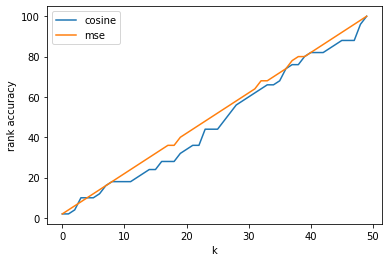

In [127]:
report(X_test, y_test)

In [128]:
inputs = tf.keras.Input(shape=(256,), dtype="float32")
x = layers.Dense(128, activation="relu")(inputs)
predictions = layers.Dense(256, activation="linear", name="predictions")(x)
x = layers.Dense(128, activation="tanh")(x)
model = tf.keras.Model(inputs, predictions)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[CosineSimilarity(axis=1)])

In [129]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
predictions (Dense)          (None, 256)               33024     
Total params: 65,920
Trainable params: 65,920
Non-trainable params: 0
_________________________________________________________________


In [130]:
n_epochs = 20
history = model.fit(X_train, y_train, epochs = n_epochs)

Epoch 1/20
5/5 [==============================] - 0s 1ms/step - loss: 1.2028 - cosine_similarity: 0.0196
Epoch 2/20
5/5 [==============================] - 0s 944us/step - loss: 1.2322 - cosine_similarity: 0.1164
Epoch 3/20
5/5 [==============================] - 0s 932us/step - loss: 1.3402 - cosine_similarity: 0.1910
Epoch 4/20
5/5 [==============================] - 0s 920us/step - loss: 1.1859 - cosine_similarity: 0.2240
Epoch 5/20
5/5 [==============================] - 0s 945us/step - loss: 1.2106 - cosine_similarity: 0.2566
Epoch 6/20
5/5 [==============================] - 0s 1ms/step - loss: 1.1795 - cosine_similarity: 0.2657
Epoch 7/20
5/5 [==============================] - 0s 912us/step - loss: 1.1662 - cosine_similarity: 0.2794
Epoch 8/20
5/5 [==============================] - 0s 1ms/step - loss: 1.1675 - cosine_similarity: 0.2854
Epoch 9/20
5/5 [==============================] - 0s 926us/step - loss: 1.1364 - cosine_similarity: 0.2971
Epoch 10/20
5/5 [==========================

Cosine Similarity

MSE: 
Average MSE:  1.1892922
Rank 1 MSE Similarity Accuracy:  2.0 %
Rank 5 MSE Similarity Accuracy:  10.0 %
Rank 10 MSE Similarity Accuracy:  22.0 %
Cosine: 
Average Cosine Similarity:  0.21739815
Rank 1 Cosine Similarity Accuracy:  0.0 %
Rank 5 Cosine Similarity Accuracy:  12.0 %
Rank 10 Cosine Similarity Accuracy:  26.0 %


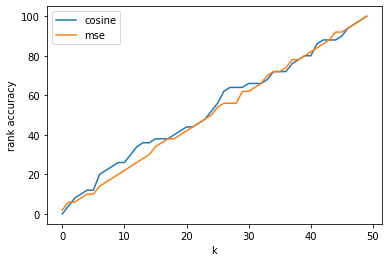

In [131]:
pred_word_emb = model.predict(X_test, verbose = 0)
report(pred_word_emb, y_test)

not sure why these are different, but I'd put it down to the l2 norms

MSE



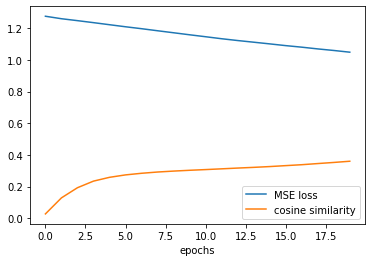

In [132]:
plt.plot(range(n_epochs), history.history["loss"])
plt.plot(range(n_epochs), history.history["cosine_similarity"])
plt.legend(["MSE loss", "cosine similarity"])
plt.xlabel("epochs")
plt.show()